# AI Agent
---
Develop AI agent with 2 tools: `attendance policy retrieval` and `employee single view SQL database`

In [1]:
from dotenv import load_dotenv

In [2]:
load_dotenv(override=True)

True

## Tools
---
Prepare tools for AI agent.

### Attendance Policy

In [3]:
from langchain_openai import OpenAIEmbeddings # AzureOpenAIEmbeddings

In [4]:
# initialize
# openai_api_version = "2024-02-01"
# embedding_azure_deployment = "text-embedding-3-large"
# embeddings = AzureOpenAIEmbeddings(
#     azure_deployment=embedding_azure_deployment,
#     openai_api_version=openai_api_version,
# )

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [5]:
from langchain_chroma import Chroma

In [6]:
vector_store = Chroma(
    collection_name="attendance_policy",
    embedding_function=embeddings,
    persist_directory="./vector_store",
)

In [7]:
vector_store._collection.count()

12

In [8]:
from langchain_core.tools import tool

In [9]:
policy_retrieval = vector_store.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 5}
)

In [10]:
@tool
def get_attendance_policy(query: str) -> str:
    """Use this tool to retrieve company attendance policies."""
    similar_docs = policy_retrieval.invoke(query)  
    doc_content = ""
    for doc in similar_docs:
        doc_content += doc.page_content
        doc_content += "\n\n"
    return doc_content

### Employee Single View
SQL database tool.

In [11]:
from langchain_community.utilities import SQLDatabase

In [12]:
# SQLite connects to file-based databases
db = SQLDatabase.from_uri("sqlite:///employee.db")

In [13]:
print(db.get_usable_table_names())

['employee_single_view']


In [14]:
from langchain_openai import ChatOpenAI # AzureChatOpenAI

In [15]:
# initialize
# openai_api_version = "2024-02-01"
# llm_azure_deployment = "gpt-4o"
# model_version = "2024-08-06" # "2024-05-13"
# llm = AzureChatOpenAI(
#     openai_api_version=openai_api_version,
#     azure_deployment=llm_azure_deployment,
#     model_version=model_version,
#     temperature=0
# )

llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0
)

#### Pre-built Agent

In [17]:
from langchain_community.agent_toolkits import create_sql_agent

In [18]:
agent_executor = create_sql_agent(llm, db=db, agent_type="openai-tools", verbose=True)

In [19]:
agent_executor.invoke({"input": "Who are the oldest employee?"})



> Entering new SQL Agent Executor chain...

Invoking: `sql_db_list_tables` with `{}`


employee_single_view
Invoking: `sql_db_schema` with `{'table_names': 'employee_single_view'}`



CREATE TABLE employee_single_view (
	"EmployeeID" BIGINT, 
	"Age" BIGINT, 
	"Gender" TEXT, 
	"MaritalStatus" TEXT, 
	"EducationLevel" TEXT, 
	"Dependents" BIGINT, 
	"TenureMonths" BIGINT, 
	"Department" TEXT, 
	"JobRole" TEXT, 
	"EmploymentType" TEXT, 
	"WorkLocation" TEXT, 
	"SalaryLevel" BIGINT, 
	"SalaryGrowthRate" FLOAT, 
	"PromotionLast12Months" BIGINT, 
	"TrainingHoursCompleted" BIGINT, 
	"JobLevel" BIGINT, 
	"PerformanceRating" BIGINT, 
	"OnPIP" BIGINT, 
	"OvertimeHours" BIGINT, 
	"RecentProjectAssignment" BIGINT, 
	"WorkShift" TEXT, 
	"SatisfactionScore" FLOAT, 
	"WorkLifeBalanceScore" FLOAT, 
	"ManagerFeedbackRating" FLOAT, 
	"TeamEngagementIndex" FLOAT, 
	"WellnessProgramParticipation" BIGINT, 
	"AbsenceDaysLast6Months" BIGINT, 
	"SickLeaveFrequency" BIGINT, 
	"LateArrivalsFrequency" BIGINT, 


{'input': 'Who are the oldest employee?',
 'output': 'The oldest employees in the database are:\n\n1. EmployeeID 17, Age 59, JobRole: Analyst, Department: Marketing\n2. EmployeeID 177, Age 59, JobRole: Manager, Department: Marketing\n3. EmployeeID 29, Age 58, JobRole: Specialist, Department: Finance\n4. EmployeeID 96, Age 58, JobRole: Manager, Department: HR\n5. EmployeeID 103, Age 58, JobRole: Specialist, Department: IT\n6. EmployeeID 120, Age 58, JobRole: Specialist, Department: HR\n7. EmployeeID 148, Age 58, JobRole: Consultant, Department: IT\n8. EmployeeID 158, Age 58, JobRole: Manager, Department: Sales\n9. EmployeeID 164, Age 58, JobRole: Developer, Department: Marketing\n10. EmployeeID 10, Age 57, JobRole: Specialist, Department: Sales'}

#### Toolkit

In [25]:
from langchain_community.agent_toolkits.sql.toolkit import SQLDatabaseToolkit

In [26]:
toolkit = SQLDatabaseToolkit(db=db, llm=llm)

In [28]:
for t in toolkit.get_tools():
    print(t.name)

sql_db_query
sql_db_schema
sql_db_list_tables
sql_db_query_checker


In [29]:
from langchain import hub

In [30]:
prompt_template = hub.pull("langchain-ai/sql-agent-system-prompt")

assert len(prompt_template.messages) == 1
print(prompt_template.input_variables)

['dialect', 'top_k']


In [31]:
system_message = prompt_template.format(dialect="SQLite", top_k=5)

In [32]:
from langgraph.prebuilt import create_react_agent

In [33]:
agent_executor = create_react_agent(
    llm, toolkit.get_tools(), state_modifier=system_message
)

In [38]:
from IPython.display import Image

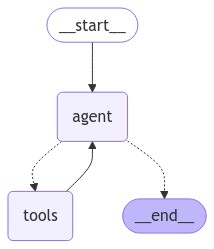

In [40]:
Image(agent_executor.get_graph().draw_mermaid_png())

In [41]:
example_query = "Who are the oldest employee?"

events = agent_executor.stream(
    {"messages": [("user", example_query)]},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Who are the oldest employee?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_1FauWXj79RS8zVEluHxKY0lI)
 Call ID: call_1FauWXj79RS8zVEluHxKY0lI
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

employee_single_view
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_RgEHabR0WVAoxbUDN5WN172A)
 Call ID: call_RgEHabR0WVAoxbUDN5WN172A
  Args:
    table_names: employee_single_view
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE employee_single_view (
	"EmployeeID" BIGINT, 
	"Age" BIGINT, 
	"Gender" TEXT, 
	"MaritalStatus" TEXT, 
	"EducationLevel" TEXT, 
	"Dependents" BIGINT, 
	"TenureMonths" BIGINT, 
	"Department" TEXT, 
	"JobRole" TEXT, 
	"Employm

In [42]:
example_query = "Which department has the most salary?"

events = agent_executor.stream(
    {"messages": [("user", example_query)]},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Which department has the most salary?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_CZpeQ4evZ3MhqlcTsXuCwXSn)
 Call ID: call_CZpeQ4evZ3MhqlcTsXuCwXSn
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

employee_single_view
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_UU54hw3WyCBZNH8qRyl101Pn)
 Call ID: call_UU54hw3WyCBZNH8qRyl101Pn
  Args:
    table_names: employee_single_view
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE employee_single_view (
	"EmployeeID" BIGINT, 
	"Age" BIGINT, 
	"Gender" TEXT, 
	"MaritalStatus" TEXT, 
	"EducationLevel" TEXT, 
	"Dependents" BIGINT, 
	"TenureMonths" BIGINT, 
	"Department" TEXT, 
	"JobRole" TEXT, 


#### LangGraph

In [34]:
from langgraph.graph import MessagesState, START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage

In [35]:
class Agent:

    def __init__(self, model, tools, memory, system_prompt=""):
        self.model = model.bind_tools(tools)
        self.tools = tools
        self.memory = memory
        self.system_prompt = system_prompt
        graph = StateGraph(MessagesState)
        graph.add_node("llm", self.call_llm)
        graph.add_node("tools", ToolNode(self.tools))
        # graph.add_edge(START, "assistant")
        graph.add_conditional_edges(
            "llm",
            # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
            # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
            tools_condition,
        )
        graph.add_edge("tools", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile(checkpointer=self.memory)

    def call_llm(self, state: MessagesState):
        messages = state['messages']
        if self.system_prompt:
            messages = [SystemMessage(content=self.system_prompt)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

In [36]:
system_prompt = """
You are an agent designed to assist with HR analytics using two toolkits: attendance policy retrieval and employee single view SQL database. Follow the instructions below to effectively utilize these toolkits.

- **Attendance Policy Questions**: Use the `get_attendance_policy` tool to retrieve relevant policies.

- **Employee Single View SQL Database Questions**:
  - Use the following sequence of SQL toolkits:
    1. `sql_db_list_tables`
    2. `sql_db_schema`
    3. `sql_db_query_checker`
    4. `sql_db_query`
  - Create a syntactically correct SQLite query to address the user's question.
  - Limit the query to at most 5 results unless the user specifies otherwise.
  - Order the results by a relevant column to provide the most interesting examples.
  - Only query for relevant columns, not all columns from a table.
  - Double-check your query for correctness before execution.
  - If an error occurs during execution, rewrite and retry the query.
  - Do not perform any DML operations (INSERT, UPDATE, DELETE, DROP, etc.).

- **Non-Toolkit Related Questions**: Inform the user that you can only assist with attendance policy and employee-related questions.

# Steps

1. Determine if the question is related to attendance policy or employee data.
2. For attendance policy questions, use the `get_attendance_policy` tool.
3. For employee data questions, follow the SQL toolkit sequence to construct and execute a query.
4. If the question is unrelated to the toolkits, inform the user of your limitations.

# Output Format

- Provide a clear and concise answer based on the retrieved data or policy.
- For SQL queries, present the results in a tabular format or as a list, highlighting key information.

# Examples

**Example 1: Attendance Policy Question**
- **Input**: "What is the policy for remote work attendance?"
- **Output**: Use `get_attendance_policy` to retrieve and present the relevant policy details.

**Example 2: Employee Data Question**
- **Input**: "Show me the top 5 employees with the highest attendance this month."
- **Output**: 
  - Use SQL toolkits to construct a query.
  - Present the top 5 employees with their attendance records.

# Notes

- Always ensure the query is syntactically correct and relevant to the question.
- Handle errors gracefully by rewriting and retrying queries if necessary.
- Clearly communicate any limitations in your capabilities to the user.
""".strip()

In [37]:
get_attendance_policy

StructuredTool(name='get_attendance_policy', description='Use this tool to retrieve company attendance policies.', args_schema=<class 'langchain_core.utils.pydantic.get_attendance_policy'>, func=<function get_attendance_policy at 0x10fd74280>)

In [38]:
from langchain_community.agent_toolkits.sql.toolkit import SQLDatabaseToolkit

In [39]:
toolkit = SQLDatabaseToolkit(db=db, llm=llm)

In [40]:
tools = toolkit.get_tools()
tools.append(get_attendance_policy)
len(tools)

5

In [41]:
for t in tools:
    print(t.name)

sql_db_query
sql_db_schema
sql_db_list_tables
sql_db_query_checker
get_attendance_policy


In [42]:
from langgraph.checkpoint.memory import MemorySaver

In [43]:
ai_agent = Agent(
    model=llm,
    tools=tools,
    memory=MemorySaver(),
    system_prompt=system_prompt
)

In [44]:
from IPython.display import Image

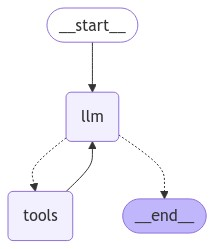

In [45]:
Image(ai_agent.graph.get_graph().draw_mermaid_png())

In [46]:
import uuid

In [47]:
thread_id = str(uuid.uuid4())
print(f"Thread ID: {thread_id}")
# Specify a thread
config = {"configurable": {"thread_id": thread_id}}

Thread ID: cd1ea065-10be-41b2-a0bf-0d3320205217


In [48]:
# run
user_input = "What working hours employees are expected to work?"
messages = [HumanMessage(content=user_input)]
events = ai_agent.graph.stream({"messages": messages}, config, stream_mode="values")

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What working hours employees are expected to work?
================================== Ai Message ==================================
Tool Calls:
  get_attendance_policy (call_lZVVBqE1JZwacaFtxABssFt1)
 Call ID: call_lZVVBqE1JZwacaFtxABssFt1
  Args:
    query: working hours policy
================================= Tool Message =================================
Name: get_attendance_policy

**3. Work Schedule**    
- Regular working hours are from [insert time, e.g., 9:00 AM to 5:00 PM], Monday through Friday. Employees are expected to adhere to these hours unless otherwise specified.    
- Employees are expected to take scheduled breaks (e.g., a 1-hour lunch break and two 15-minute breaks) and ensure adherence to standard working hours. Breaks are designed to promote well-being, productivity, and mental refreshment, which in turn leads to better performance and focus.  
- Supervisors may occasionally adjust 

In [49]:
# run
user_input = "Which department has the most total salary?"
messages = [HumanMessage(content=user_input)]
events = ai_agent.graph.stream({"messages": messages}, config, stream_mode="values")

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Which department has the most total salary?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_azn1Hw9jAhrrEvPZqgaC1NdG)
 Call ID: call_azn1Hw9jAhrrEvPZqgaC1NdG
  Args:
  sql_db_schema (call_0eMIkyOMizymeJvHPQ0ehNZn)
 Call ID: call_0eMIkyOMizymeJvHPQ0ehNZn
  Args:
    table_names: departments, employees
================================= Tool Message =================================
Name: sql_db_schema

Error: table_names {'employees', 'departments'} not found in database
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_JyAptp2o7nECWG9XLXK8PAa3)
 Call ID: call_JyAptp2o7nECWG9XLXK8PAa3
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

employee_single_view
================================== Ai Message ====